In [4]:
"""
Enhanced LangGraph Simulation and Dashboard with Token Cost Calculation and Analysis (10,000 Iterations)

This script updates the state structure to record additional metrics:
- A token counter is added (initialized with a random integer between 100 and 400)
  and is incremented by a random integer between 400 and 700 on each node/tool visit.
- Token cost calculations for various models are computed based on final token counts.

The script runs 10,000 iterations and uses Plotly to visualize:
- Distributions of run lengths, tool usage, termination reasons, and node visits.
- Aggregated metrics per simulation bin.
- Distribution of token costs per model as well as a histogram of final token counts.
- A summary table of token cost statistics.
Each grouped figure is saved as a PNG file.
"""

import random
from typing import Literal, Dict
from typing_extensions import TypedDict
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Import LangGraph components
from langgraph.graph import StateGraph, START, END

# --------------------------
# Simulation Code
# --------------------------

# Updated state schema: now tracking tokens along with additional metrics.
class TypedDictState(TypedDict):
    tools_called: int
    condition: Literal["good", "bad"]
    steps: int
    node_visits: Dict[str, int]
    termination_reason: str
    tool_1_count: int
    tool_2_count: int
    token: int  # New token parameter

# Helper function to record node visits, steps, and update tokens.
def record_visit(state: TypedDictState, node_name: str):
    state["steps"] += 1
    state["node_visits"][node_name] = state["node_visits"].get(node_name, 0) + 1
    # Increment tokens by a random value between 400 and 700 each time.
    state["token"] += random.randint(400, 700)

# Node definitions
def node_1(state: TypedDictState):
    record_visit(state, "node_1")
    return {
        "tools_called": state["tools_called"],
        "steps": state["steps"],
        "node_visits": state["node_visits"],
        "tool_1_count": state["tool_1_count"],
        "tool_2_count": state["tool_2_count"],
        "token": state["token"],
    }

def tool_1(state: TypedDictState):
    record_visit(state, "tool_1")
    state["tools_called"] += 1
    state["tool_1_count"] += 1
    state["condition"] = "good"
    return {
        "condition": state["condition"],
        "tools_called": state["tools_called"],
        "steps": state["steps"],
        "node_visits": state["node_visits"],
        "tool_1_count": state["tool_1_count"],
        "tool_2_count": state["tool_2_count"],
        "token": state["token"],
    }

def tool_2(state: TypedDictState):
    record_visit(state, "tool_2")
    state["tools_called"] += 1
    state["tool_2_count"] += 1
    state["condition"] = "bad"
    state["termination_reason"] = "tool_2 branch termination"
    return {
        "condition": state["condition"],
        "tools_called": state["tools_called"],
        "steps": state["steps"],
        "node_visits": state["node_visits"],
        "termination_reason": state["termination_reason"],
        "tool_1_count": state["tool_1_count"],
        "tool_2_count": state["tool_2_count"],
        "token": state["token"],
    }

def node_2(state: TypedDictState):
    record_visit(state, "node_2")
    if state["tools_called"] > 55:
        state["termination_reason"] = "tools limit exceeded"
    else:
        state["termination_reason"] = "node_2 reached"
    return {
        "tools_called": state["tools_called"],
        "steps": state["steps"],
        "node_visits": state["node_visits"],
        "termination_reason": state["termination_reason"],
        "tool_1_count": state["tool_1_count"],
        "tool_2_count": state["tool_2_count"],
        "token": state["token"],
    }

# Decision functions
def decide_condition(state: TypedDictState) -> Literal["tool_1", "tool_2"]:
    # With a 95% chance, go to tool_1; with a 5% chance, go to tool_2.
    return "tool_1" if random.random() < 0.95 else "tool_2"

def decide_condition_2(state: TypedDictState):
    # If tools_called exceeds 55, proceed to node_2 (termination step); otherwise, loop back to node_1.
    return "node_2" if state["tools_called"] > 55 else "node_1"

# Build and compile the graph
builder = StateGraph(TypedDictState)
builder.add_node("node_1", node_1)
builder.add_node("tool_1", tool_1)
builder.add_node("tool_2", tool_2)
builder.add_node("node_2", node_2)

builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_condition)
builder.add_conditional_edges("tool_1", decide_condition_2)
builder.add_edge("tool_2", "node_2")
builder.add_edge("node_2", END)

graph = builder.compile()

# Cost rates in USD per 1 million tokens for each model.
cost_rates = {
    "gpt_4o": 30,
    "o1_mini": 5,
    "o1": 10,
    "o3_mini": 7,
    "claude_sonnet_3_5": 25,
    "gemini_2_0_pro": 15,
    "gemini_2_0_flash": 12,
    "gemini_1_5_pro": 8,
    "gemini_1_5_flash": 5,
}

# Function to run one simulation and return the final state metrics.
def run_simulation():
    initial_state: TypedDictState = {
        "tools_called": 0,
        "condition": "good",
        "steps": 0,
        "node_visits": {},
        "termination_reason": "",
        "tool_1_count": 0,
        "tool_2_count": 0,
        "token": random.randint(100, 400),  # Initialize token with a random value between 100 and 400.
    }
    final_state = graph.invoke(initial_state, {"recursion_limit": 200})
    return final_state

# Run 10,000 iterations
n_iterations = 10_000
simulation_records = []
aggregate_node_visits = {}

for i in range(n_iterations):
    if i % 1000 == 0:
        print(f"Running simulation {i+1} of {n_iterations}...")
    state = run_simulation()
    record = {
        "steps": state["steps"],
        "tools_called": state["tools_called"],
        "termination_reason": state["termination_reason"],
        "final_condition": state["condition"],
        "node_1": state["node_visits"].get("node_1", 0),
        "tool_1": state["node_visits"].get("tool_1", 0),
        "tool_2": state["node_visits"].get("tool_2", 0),
        "node_2": state["node_visits"].get("node_2", 0),
        "tool_1_count": state["tool_1_count"],
        "tool_2_count": state["tool_2_count"],
        "token": state["token"],
    }
    # Calculate token cost for each model.
    for model_key, rate in cost_rates.items():
        record[f"cost_{model_key}"] = state["token"] / 1_000_000 * rate

    simulation_records.append(record)
    
    # Aggregate node visits for overall frequency.
    for node, count in state["node_visits"].items():
        aggregate_node_visits[node] = aggregate_node_visits.get(node, 0) + count

df = pd.DataFrame(simulation_records)

# Identify cost columns for later use.
cost_columns = [col for col in df.columns if col.startswith("cost_")]


Running simulation 1 of 10000...
Running simulation 1001 of 10000...
Running simulation 2001 of 10000...
Running simulation 3001 of 10000...
Running simulation 4001 of 10000...
Running simulation 5001 of 10000...
Running simulation 6001 of 10000...
Running simulation 7001 of 10000...
Running simulation 8001 of 10000...
Running simulation 9001 of 10000...


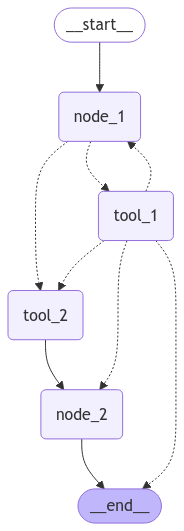

In [2]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [7]:
# --------------------------
# Create and Save Each Plot Separately
# --------------------------

# Visualization 1: Distribution of Run Lengths (Steps)
fig1 = px.histogram(df, x="steps", nbins=100, title="Dist. of Count of Steps to reach END",color_discrete_sequence=["steelblue"])
fig1.update_layout(
    xaxis_title="Number of Steps",
    yaxis_title="Frequency",
    annotations=[dict(
        x=0.5, y=1.08, xref="paper", yref="paper",
        text="Representation of the distribution of run lengths (steps) across all simulations.",
        showarrow=False, font=dict(size=10)
    )]
)
fig1.write_image("viz1_run_length_steps.png")
fig1.show()

# Visualization 2: Distribution of Tools Called
fig2 = px.histogram(df, x="tools_called", nbins=100, title="Dist. of Count of Tools Calling",color_discrete_sequence=["royalblue"])
fig2.update_layout(
    xaxis_title="Tools Called",
    yaxis_title="Frequency",
    annotations=[dict(
        x=0.5, y=1.08, xref="paper", yref="paper",
        text="How frequent is it to call the tools?",
        showarrow=False, font=dict(size=10)
    )]
)
fig2.write_image("viz2_tools_called.png")
fig2.show()

# Visualization 3: Termination Reasons Pie Chart
fig3 = px.pie(df, names="termination_reason", title="Termination Reasons", hole=0.5)
fig3.update_layout(
    annotations=[dict(
        x=0.5, y=1.08, xref="paper", yref="paper",
        text="Percentage of frequencies ended up with various termination reasons.",
        showarrow=False, font=dict(size=10)
    )]
)
fig3.write_image("viz3_termination_pie.png")
fig3.show()

# Visualization 4: Aggregated Node Visit Frequencies (Bar Chart)
agg_df = pd.DataFrame({
    "Node": list(aggregate_node_visits.keys()),
    "Visits": list(aggregate_node_visits.values())
})
fig4 = px.bar(agg_df, x="Node", y="Visits", title="Aggregated Node Visit Frequencies", color="Node")
fig4.update_layout(
    xaxis_title="Node",
    yaxis_title="Total Visits",
    annotations=[dict(
        x=0.5, y=1.08, xref="paper", yref="paper",
        text="Out of 10,000 simulations, how many times each node was visited?",
        showarrow=False, font=dict(size=10)
    )]
)
fig4.write_image("viz4_agg_node_visits.png")
fig4.show()

# Visualization 5: Run Length (Steps) by Termination Reason (Violin Plot)
fig5 = px.violin(df, x="termination_reason", y="steps", box=True, points="all",
                 title="Steps by Termination Reason")
fig5.update_layout(
    xaxis_title="Termination Reason",
    yaxis_title="Steps",
    annotations=[dict(
        x=0.5, y=1.08, xref="paper", yref="paper",
        text="Plot represents which termination reason is likely to happen after a certain length.",
        showarrow=False, font=dict(size=10)
    )]
)
fig5.write_image("viz5_run_length_violin.png")
fig5.show()

# Visualization 6: Tools Called by Termination Reason (Violin Plot)
fig6 = px.violin(df, x="termination_reason", y="tools_called", box=True, points="all",
                 title="Tools Called by Termination Reason")
fig6.update_layout(
    xaxis_title="Termination Reason",
    yaxis_title="Tools Called",
    annotations=[dict(
        x=0.5, y=1.08, xref="paper", yref="paper",
        text="Plot represents the distribution of number of tools called per termination reason.",
        showarrow=False, font=dict(size=10)
    )]
)
fig6.write_image("viz6_tools_called_violin.png")
fig6.show()

# Visualization 7: Steps vs. Tools Called Density Heatmap
hist, xedges, yedges = np.histogram2d(df["steps"], df["tools_called"], bins=(30, 30))
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
fig7 = go.Figure(data=go.Heatmap(x=x_centers, y=y_centers, z=hist.T, colorscale="Viridis",
                                 colorbar=dict(title="Count")))
fig7.update_layout(
    title="Steps vs. Tools Called Density",
    xaxis_title="Steps",
    yaxis_title="Tools Called",
    annotations=[dict(
        x=0.5, y=1.08, xref="paper", yref="paper",
        text="The density represents how often a combination of steps and tools called occurred.",
        showarrow=False, font=dict(size=10)
    )]
)
fig7.write_image("viz7_density_heatmap.png")
fig7.show()

# Visualization 8: Aggregated Metrics Heatmap per Simulation Bin
fig8 = px.imshow(heatmap_grouped, text_auto=True, aspect="auto",
                 title="Average Node Visits & Steps per Simulation")
fig8.update_layout(
    xaxis_title="Metric",
    yaxis_title="Simulation Bin",
    annotations=[dict(
        x=0.5, y=1.08, xref="paper", yref="paper",
        text="Heatmap of averaged metrics per simulation bin.",
        showarrow=False, font=dict(size=10)
    )]
)
fig8.write_image("viz8_aggregated_metrics_heatmap.png")
fig8.show()

# Visualization 9: Distribution of Tool_1 Usage
fig9 = px.histogram(df, x="tool_1_count", nbins=100, title="Distribution of Tool_1 Usage")
fig9.update_layout(
    xaxis_title="Tool 1 Count",
    yaxis_title="Frequency",
    annotations=[dict(
        x=0.5, y=1.08, xref="paper", yref="paper",
        text="Dist. of Tool 1 being called across simulations.",
        showarrow=False, font=dict(size=10)
    )]
)
fig9.write_image("viz9_tool1_usage.png")
fig9.show()

# Visualization 10: Distribution of Tool_2 Usage
fig10 = px.histogram(df, x="tool_2_count", nbins=50, title="Distribution of Tool_2 Usage")
fig10.update_layout(
    xaxis_title="Tool 2 Count",
    yaxis_title="Frequency",
    annotations=[dict(
        x=0.5, y=1.08, xref="paper", yref="paper",
        text="Dist. of Tool 2 being called across simulations.",
        showarrow=False, font=dict(size=10)
    )]
)
fig10.write_image("viz10_tool2_usage.png")
fig10.show()

# Visualization 11: Distribution of Token Costs per Model (Violin Plot)
fig11 = px.violin(df_costs, x="model", y="cost", box=True, points="all",
                  title="Distribution of Token Costs per Model")
fig11.update_layout(
    xaxis_title="Model",
    yaxis_title="Cost ($)",
    annotations=[dict(
        x=0.5, y=1.08, xref="paper", yref="paper",
        text="Token cost distributions per model (per 1M tokens).",
        showarrow=False, font=dict(size=10)
    )]
)
fig11.write_image("viz11_token_costs_violin.png")
fig11.show()

# Visualization 12: Distribution of Final Token Count
fig12 = px.histogram(df, x="token", nbins=100, title="Distribution of Final Token Count")
fig12.update_layout(
    xaxis_title="Token Count",
    yaxis_title="Frequency",
    annotations=[dict(
        x=0.5, y=1.08, xref="paper", yref="paper",
        text="Token counts across all simulation runs.",
        showarrow=False, font=dict(size=10)
    )]
)
fig12.write_image("viz12_final_token_count.png")
fig12.show()

# Visualization 13: Summary Table of Token Cost Statistics per Model
token_cost_stats = df[cost_columns].describe().T[['mean', 'std', 'min', '50%', 'max']].round(2)
fig13 = go.Figure(data=[go.Table(
    header=dict(values=["Model"] + list(token_cost_stats.columns),
                fill_color='paleturquoise', align='left'),
    cells=dict(values=[token_cost_stats.index,
                       token_cost_stats['mean'],
                       token_cost_stats['std'],
                       token_cost_stats['min'],
                       token_cost_stats['50%'],
                       token_cost_stats['max']],
               fill_color='lavender', align='left'))
])
fig13.update_layout(
    title="Token Cost Statistics per Model",
    annotations=[dict(
        x=0.5, y=1.05, xref="paper", yref="paper",
        text="Summary table of token cost statistics (mean, std, min, median, max) per model.",
        showarrow=False, font=dict(size=10)
    )]
)
fig13.write_image("viz13_token_costs_table.png")
fig13.show()


In [2]:
df.head()

steps  tools_called         termination_reason
0     52            26  node_3 branch termination
1     30            15  node_3 branch termination
2     86            43  node_3 branch termination
3    106            53  node_3 branch termination
4     14             7  node_3 branch termination